# African Airlines Sentiment Analysis (2015-Present)
**Data Cleaning & Preprocessing** | Creating interim and fully processed datasets

This notebook creates 2 datasets for further analysis (1 interim dataset and 1 fully processed dataset). The two datasets and how they differ are discussed below:

1. **Interim Dataset (airlines_categorical.csv)** : Here the review text in the dataset is lowercased and the attribute ratings (e.g. seat_comfort, cabin_staff_service) are converted to sentiment categories with the following key: {1.0:'Negative', 2.0:'Negative', 3.0:'Neutral', 4.0:'Positive', 5.0:'Positive'}

2. **Fully processed Dataset (airlines_processed.csv)**: Here the conversion of ratings to sentiment categories (as outlined above) is also carried out. However, a lot more preprocessing is carried out on the text: lowercasing, stopword removal, punctuation removal and numbers removal.

### 1. Library Importation

In [6]:
#Packages for data loading and manipulation
import pandas as pd
import numpy as np
from datetime import datetime as dt

#Visualization packages
import seaborn as sns
import missingno
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline

#Packages for text cleaning
from cleantext.cleantext import clean
import nltk
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/koredeakande/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 2. Loading the data 

In [7]:
airlines_df = pd.read_csv('../data/raw/african_airlines.csv',index_col=0)

In [8]:
airlines_df.head()

,Subject,date_published,verified,review_text,aircraft,type_of_traveller,seat_type,route,date_flown,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity,value_for_money,recommended
0,ethiopian-airlines,2021-01-31 00:08:00,True,I've flown Ethiopian Airlines a couple of time...,Boeing 777,Business,Economy Class,Addis Ababa to Washington,August 2021,2.0,1.0,1.0,1.0,2.0,1.0,1.0,no
1,ethiopian-airlines,2021-01-06 00:08:00,True,Fantastic journey. Flew on a Q400 turbo prop f...,Q400 / A350-900,Solo Leisure,Economy Class,Khartoum to Kilimanjaro via Addis Ababa,July 2021,5.0,5.0,5.0,5.0,5.0,NaN,5.0,yes
2,ethiopian-airlines,2021-01-29 00:07:00,True,My children are stuck in transit in Ethiopia a...,NaN,Family Leisure,Economy Class,Kilimanjaro to Johannesburg via Addis Ababa,July 2021,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no
3,ethiopian-airlines,2021-01-17 00:07:00,False,"Average to below average. Dirty, dated 767 on ...",Boeing 767,Business,Economy Class,Johannesburg to Addis Ababa,July 2021,1.0,2.0,2.0,1.0,1.0,NaN,3.0,no
4,ethiopian-airlines,2021-01-10 00:07:00,True,Due to cancellation of my KQ flight EBB-NBO-JN...,NaN,Solo Leisure,Business Class,Entebbe to Johannesburg via Addis Ababa,June 2021,4.0,4.0,3.0,2.0,2.0,NaN,3.0,yes


In [9]:
print(airlines_df.shape)

(1256, 17)


### 3. Exploratory Data Analysis (EDA) for cleaning

In [187]:
profile = ProfileReport(airlines_df, title="African Airlines Profiling Report", explorative=True)

In [188]:
profile

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile.to_file("../reports/african_airlines_eda_report.html")

In [99]:
airlines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Subject                 1256 non-null   object 
 1   date_published          1256 non-null   object 
 2   verified                894 non-null    object 
 3   review_text             1256 non-null   object 
 4   aircraft                639 non-null    object 
 5   type_of_traveller       1170 non-null   object 
 6   seat_type               1256 non-null   object 
 7   route                   1170 non-null   object 
 8   date_flown              1170 non-null   object 
 9   seat_comfort            1184 non-null   float64
 10  cabin_staff_service     1179 non-null   float64
 11  food_&_beverages        1110 non-null   float64
 12  inflight_entertainment  882 non-null    float64
 13  ground_service          1127 non-null   float64
 14  wifi_&_connectivity     226 non-null    

### 4. Data Cleaning & Reformatting

#### a. Data Type Conversion

In [10]:
#Convert data published column to datetime object
airlines_df.date_published = pd.to_datetime(airlines_df.date_published)

#Convert recommended to integer (yes = 1 and no = 0). This will be helpful for ML algorithms
airlines_df.recommended = airlines_df.recommended.map({'yes':1, 'no': 0}, na_action = 'ignore')

#### b. Exploring & Handling missing data
Deleting Unnecessary Columns. These have high missingness and are deemed to not be contributing important info

In [11]:
#Delete verified, route, and aircraft columns
airlines_df = airlines_df.drop(columns = ['verified','route', 'aircraft'])

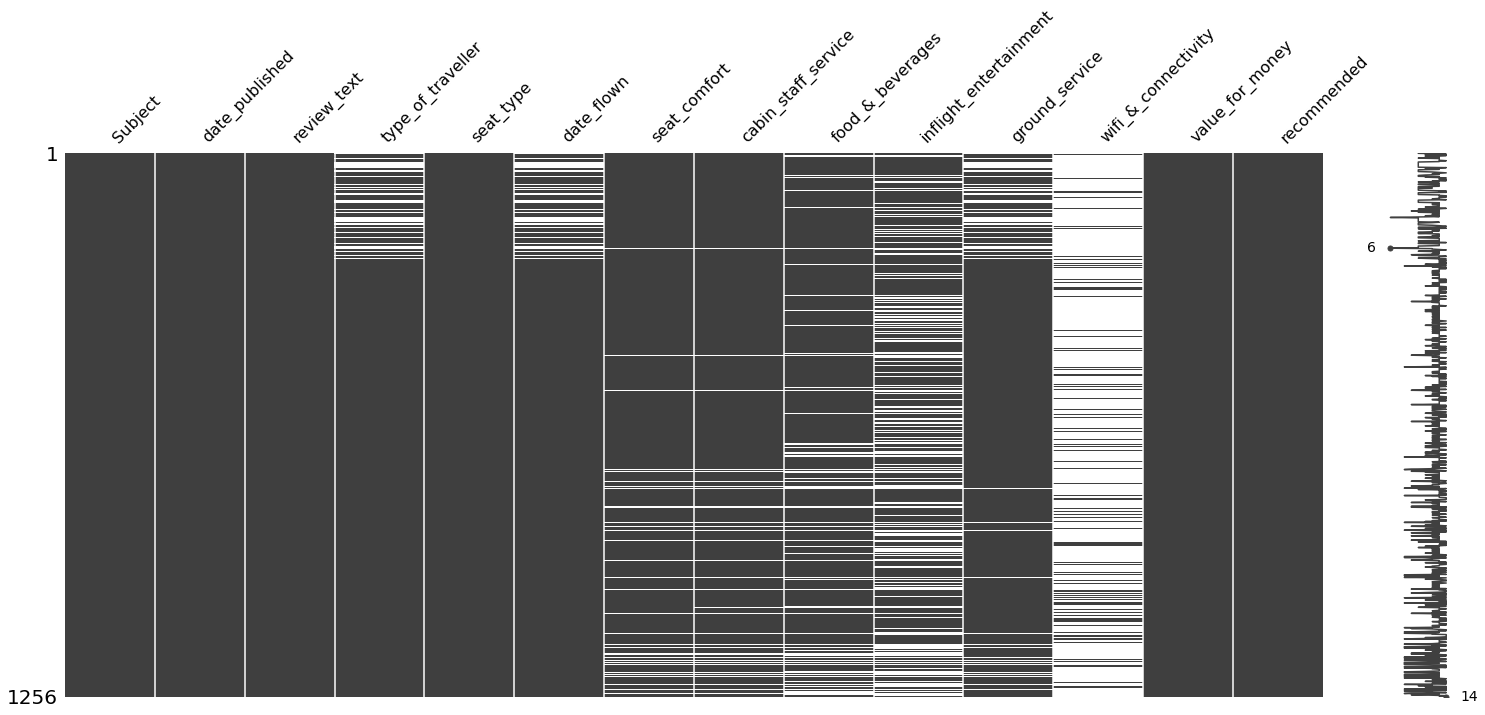

In [12]:
#Observe missingness over time
missingno.matrix(airlines_df.sort_values('date_published'))
plt.show()

From the missing value heatmap in the pandas profiling report above, we see perfect missingness correlation between *type of traveller, date flow, and route*. We also see a strong missingness correlation between *ground service* and these other variables. Since *route* has been removed, we explore reviews with the three other variables missing, looking first at the timing as the missigno plot (sorted by posting time) above suggests timing could be an important explanatory factor (i.e. the missing values for the variables of interest, happen for earlier reviews):

In [13]:
corr_missing_attrs = airlines_df[airlines_df[['type_of_traveller','date_flown','ground_service']]\
                                 .isna()\
                                 .all(axis=1)]

first_date = corr_missing_attrs.date_published.min()
last_date = corr_missing_attrs.date_published.max()

print(f"The review publishing dates range from {first_date} and {last_date}")

The review publishing dates range from 2015-01-01 00:05:00 and 2015-01-31 00:05:00


In [17]:
for idx, review in enumerate(corr_missing_attrs.review_text.sample(5)):
    print(str(idx+1) + ')',review,'\n')

1) Flight SA 40 / 41 (JNB-VIC/VIC-JNB) SA 337 (JNB-CPT) SA 420 (PZE-JNB): overall not very satisfied - complicated reservation (system problems long waits at phone etc.) long waiting at check in no preferred treatment as Star Alliance frequent flyer most of the check in staff is unfriendly some even rude. Lounges are all low quality level and also here very unfriendly staff the food at the lounges is below average. On board the staff was mostly OK. Food on all flights was not good. Seat comfort on most flights not very good except SA 337 where they use the long haul aircraft so you have much leg room. Overall an airline which I cannot recommend - unfortunately there is not much alternative within the region. 

2) We flew to Johannesburg South Africa (connecting via Adis Ababa). We had a fantastic experience. Brand new plane excellent service the in-flight entertainment works from the moment you board. Food was excellent and generous with the beverages (unlike other airlines). I recomme

In [9]:
len(airlines_df.query(f" date_published.dt.year == 2015"))

248

The perfect correlation between the missigness of these variables occurred in January 2015 and might point towards the site the data was extracted from: Skytrax. There doesn't appear to be any indicating factor from the reviews themselves (e.g. cancellations) that might point to why these were missing. Maybe the fields for these variables were not required as of 2015. They seem to be required now.

We could delete records from 2015, but this would drop the rows from about 1250 to 1000. I instead leave the rows as they still present significant information despite the missing values

We also note stretches of whitelines, suggesting that people who don't fill in one attribute are more likely to not fill in other attributes as well. This phenomenon is explored below:

In [10]:
missing_inflight_attrs = airlines_df[airlines_df.iloc[:,7:11].isna().all(axis=1)]

In [12]:
for idx, review in enumerate(missing_inflight_attrs.review_text.sample(5)):
    print(str(idx+1) + ')',review,'\n')

1) I had a booking with in April when the pandemic struck us all. They cancelled my flight. According to European regulations the airline need to offer a refund. Ethiopian Airlines never offered a refund, no matter how many times. It's November and I still haven't been able to get a refund for my tickets. 

2) Cape Town to George. I have never come across a more unprofessional, inefficient airline in my life. After having unplanned surgery days before my flight, I couldn't make my flight. As a result, (and including the travel insurance which I bought) I could not change my flight without paying the fee of the flight again and could not cancel my flight and get a refund on my booking. After calling in and being on hold, I spoke to an extremely rude woman who did not understand and could not answer my basic questions. I was told that if I were a gold-card member that I would be able to change my flight but as I am just an economy member, there is nothing they can do for me. After asking

These long stretches appear to be flight cancellations or failed reschedulings. This makes sense as these reviewers didn't ultimately board the plane and so couldn't rate inflight attributes like seat comfort, food and beverages, etc.

### 6. Data Transformation & Preprocessing

In [18]:
airlines_df.head(3)

,Subject,date_published,review_text,type_of_traveller,seat_type,date_flown,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity,value_for_money,recommended
0,ethiopian-airlines,2021-01-31 00:08:00,I've flown Ethiopian Airlines a couple of time...,Business,Economy Class,August 2021,2.0,1.0,1.0,1.0,2.0,1.0,1.0,0
1,ethiopian-airlines,2021-01-06 00:08:00,Fantastic journey. Flew on a Q400 turbo prop f...,Solo Leisure,Economy Class,July 2021,5.0,5.0,5.0,5.0,5.0,NaN,5.0,1
2,ethiopian-airlines,2021-01-29 00:07:00,My children are stuck in transit in Ethiopia a...,Family Leisure,Economy Class,July 2021,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


#### 1. Interim Preprocessing

**a. Dataframe with date_published as datetime and recommended as (numeric) boolean**

In [19]:
airlines_df.to_csv(f'../data/interim/airlines_numeric.csv')

**b. Lowering text and converting ratings to sentiment (word) categorical variables**

In [20]:
#Make copy of the dataframe for data transformation and preprocessing
transformed_df = airlines_df.copy()

#Map to convert ratings to sentiment categories
rating2category = {1.0:'Negative', 2.0:'Negative', 3.0:'Neutral', 4.0:'Positive', 5.0:'Positive'}

#Convert attribute ratings to sentiment categories: Positive, Neutral, and negative
transformed_df.iloc[:,6:13] = transformed_df.iloc[:,6:13].stack().map(rating2category).unstack()


#PREPROCESS TEXT WITH MINIMAL CLEANING – just lowercasing, leave sentences as they were
min_text_cleaning = transformed_df.copy()
min_text_cleaning.review_text = min_text_cleaning.review_text.str.lower()

In [21]:
min_text_cleaning.head(3)

,Subject,date_published,review_text,type_of_traveller,seat_type,date_flown,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity,value_for_money,recommended
0,ethiopian-airlines,2021-01-31 00:08:00,i've flown ethiopian airlines a couple of time...,Business,Economy Class,August 2021,Negative,Negative,Negative,Negative,Negative,Negative,Negative,0
1,ethiopian-airlines,2021-01-06 00:08:00,fantastic journey. flew on a q400 turbo prop f...,Solo Leisure,Economy Class,July 2021,Positive,Positive,Positive,Positive,Positive,NaN,Positive,1
2,ethiopian-airlines,2021-01-29 00:07:00,my children are stuck in transit in ethiopia a...,Family Leisure,Economy Class,July 2021,Negative,Negative,Negative,Negative,Negative,Negative,Negative,0


In [22]:
#Write dataframe to csv
min_text_cleaning.to_csv(f'../data/interim/airlines_categorical.csv')

#### 2. Final Preprocessing
**Sentiment Mapping + Lowercasing with Stopword, Punctuation and Number Removal****

In [23]:
#Make copy of the dataframe for data transformation and preprocessing
transformed_df = airlines_df.copy()

#Map to convert ratings to sentiment categories
rating2category = {1.0:'Negative', 2.0:'Negative', 3.0:'Neutral', 4.0:'Positive', 5.0:'Positive'}

#Convert attribute ratings to sentiment categories: Positive, Neutral, and negative
transformed_df.iloc[:,6:13] = transformed_df.iloc[:,6:13].stack().map(rating2category).unstack()


#PREPROCESS TEXT WITH SIGNIFICANTLY MORE CLEANING
#Make review text lower case, remove stopwords, remove punctuations and remove numbers

#I do not stem or lemmatize because some sentiment analysis packages that will be utilized do 
#these in their operation

transformed_df.review_text = transformed_df.review_text.apply(clean, lowercase=True,
                                                              stopwords=True,
                                                              punct=True, 
                                                              numbers = True)

In [24]:
transformed_df.head(3)

,Subject,date_published,review_text,type_of_traveller,seat_type,date_flown,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity,value_for_money,recommended
0,ethiopian-airlines,2021-01-31 00:08:00,ive flown ethiopian airlines couple times gene...,Business,Economy Class,August 2021,Negative,Negative,Negative,Negative,Negative,Negative,Negative,0
1,ethiopian-airlines,2021-01-06 00:08:00,fantastic journey flew q turbo prop khartoum a...,Solo Leisure,Economy Class,July 2021,Positive,Positive,Positive,Positive,Positive,NaN,Positive,1
2,ethiopian-airlines,2021-01-29 00:07:00,children stuck transit ethiopia ethiopian airl...,Family Leisure,Economy Class,July 2021,Negative,Negative,Negative,Negative,Negative,Negative,Negative,0


In [25]:
transformed_df.to_csv(f'../data/processed/airlines_processed.csv')